In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder

# Defining helpful functions:

In [61]:
#function to check chi squared value for all pairs of columns in a dataframe
def chi2_check (data):
    lst1 = []
    lst2 = []
    lst3 = []
    for i,n in enumerate(data.columns):
        x = 1
        while x < len(data.columns)-i: 
            crosstab = pd.crosstab(data[n],data[data.columns[i+x]])
            lst1.append(n)
            lst2.append(data.columns[i+x])
            lst3.append(chi2_contingency(crosstab, correction=False)[1])
            x += 1
    df = pd.concat([pd.DataFrame(lst1),pd.DataFrame(lst2),pd.DataFrame(lst3)], axis =1)
    return df

In [103]:
#function to remove outliers given the dataframe, column and k constant which adjusts the upper and lower limits
def remove_outliers(df, x, k):
    iqr = np.percentile(df[x],75) - np.percentile(df[x],25)
    upper_limit = np.percentile(df[x],75) + k*iqr
    lower_limit = np.percentile(df[x],25) - k*iqr
    df = df[(df[x]>lower_limit) & (df[x]<upper_limit)]
    return df

In [155]:
#function to take log of values in a column and return 0 for values <0
def log_transform_clean(x):
    if x>0:
        return np.log(x)
    else:
        return 0  

In [156]:
def transformations (data, name):

    data[name+"_sqrt"] = data[name]**(1/2)
    data[name+"_log"] = list(map(log_transform_clean, data[name]))

    if data[name].min() > 0:
        box_cox, lmbda = stats.boxcox(data[name])
        data[name+"_bc"]= box_cox

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20,15)) 
        plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
        sns.histplot(data[name], ax=ax1)
        sns.histplot(data[name+"_sqrt"], ax=ax2)
        sns.histplot(data[name+"_log"], ax=ax3)
        sns.histplot(data[name+"_bc"], ax=ax4)
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,5)) 
        plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
        sns.histplot(data[name], ax=ax1)
        sns.histplot(data[name+"_sqrt"], ax=ax2)
        sns.histplot(data[name+"_log"], ax=ax3)
    return data

## Importing from cleaned data:

In [109]:
df = pd.read_pickle('songlist_with_features_clean_all_genres.pickle')

In [110]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,main_genre
0,0.872,0.384,0,-16.204,1,0.0388,0.418,0.317000,0.0687,0.938,102.597,515000.0,4,Blues
1,0.699,0.633,11,-6.249,1,0.0261,0.436,0.000093,0.0291,0.907,91.398,167040.0,4,Blues
2,0.640,0.496,2,-11.124,1,0.0413,0.616,0.000046,0.1830,0.954,116.632,253333.0,4,Blues
3,0.572,0.348,0,-13.454,1,0.0293,0.438,0.000731,0.2350,0.340,73.303,275267.0,4,Blues
4,0.775,0.499,4,-7.181,1,0.0415,0.496,0.021900,0.1140,0.862,121.056,232707.0,4,Blues


## Explore Data: amount of songs per genres:

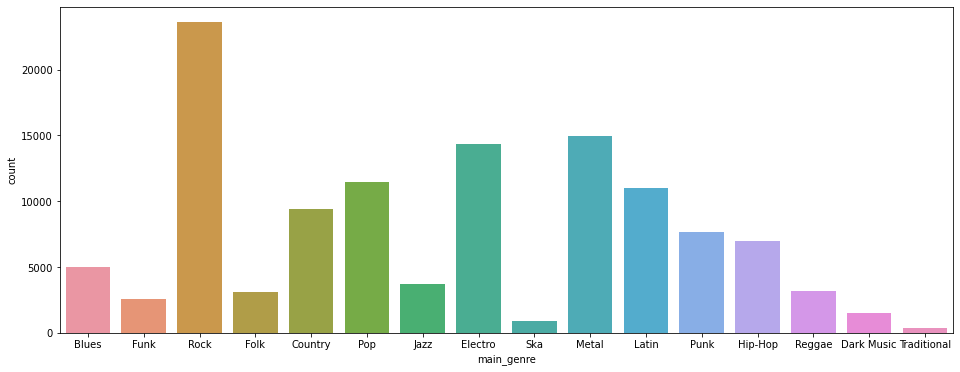

In [111]:
a4_dims = (16, 6)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.countplot(ax = ax, x = "main_genre", data = df)

Hugh Data Imbalance to keep in mind:

In [112]:
df["main_genre"].value_counts()

Rock           23600
Metal          14952
Electro        14343
Pop            11448
Latin          10974
Country         9446
Punk            7665
Hip-Hop         6971
Blues           4996
Jazz            3698
Reggae          3159
Folk            3134
Funk            2552
Dark Music      1483
Ska              938
Traditional      380
Name: main_genre, dtype: int64

## Splitting data into numerical and categorical:

In [113]:
df["key"].unique()

array([0, 11, 2, 4, 9, 3, 5, 1, 7, 10, 8, 6], dtype=object)

In [114]:
cat_columns = []
num_columns = []
threshold = 20
for name in df.columns:
    if len(df[name].unique()) > threshold:
        num_columns.append(name)
    else:
        cat_columns.append(name)

In [115]:
num = df[num_columns]
num.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.872,0.384,-16.204,0.0388,0.418,0.317000,0.0687,0.938,102.597,515000.0
1,0.699,0.633,-6.249,0.0261,0.436,0.000093,0.0291,0.907,91.398,167040.0
2,0.640,0.496,-11.124,0.0413,0.616,0.000046,0.1830,0.954,116.632,253333.0
3,0.572,0.348,-13.454,0.0293,0.438,0.000731,0.2350,0.340,73.303,275267.0
4,0.775,0.499,-7.181,0.0415,0.496,0.021900,0.1140,0.862,121.056,232707.0


In [116]:
cat = df[cat_columns]
cat.head()

,key,mode,time_signature,main_genre
0,0,1,4,Blues
1,11,1,4,Blues
2,2,1,4,Blues
3,0,1,4,Blues
4,4,1,4,Blues


## EDA -> Numericals

In [117]:
num.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,119739.0,0.556901,0.177260,0.00000,0.43600,0.561000,0.6900,0.990
energy,119739.0,0.692400,0.234023,0.00002,0.54200,0.738000,0.8880,1.000
loudness,119739.0,-7.689074,4.027611,-48.13100,-9.53150,-6.692000,-4.8840,3.744
speechiness,119739.0,0.081053,0.077741,0.00000,0.03630,0.051100,0.0903,0.949
acousticness,119739.0,0.218950,0.288542,0.00000,0.00451,0.070200,0.3450,0.996
instrumentalness,119739.0,0.134626,0.277757,0.00000,0.00000,0.000184,0.0497,0.996
liveness,119739.0,0.206987,0.180213,0.00000,0.09470,0.133000,0.2740,1.000
valence,119739.0,0.513785,0.258528,0.00000,0.30400,0.513000,0.7270,1.000
tempo,119739.0,123.366774,29.372215,0.00000,100.03200,121.983000,140.7445,247.910
duration_ms,119739.0,245625.260183,93024.001227,4812.00000,192825.00000,228187.000000,276160.0000,3816373.000


Besides "tempo", "duration_ms" and "loudness", all other features are on the same scale

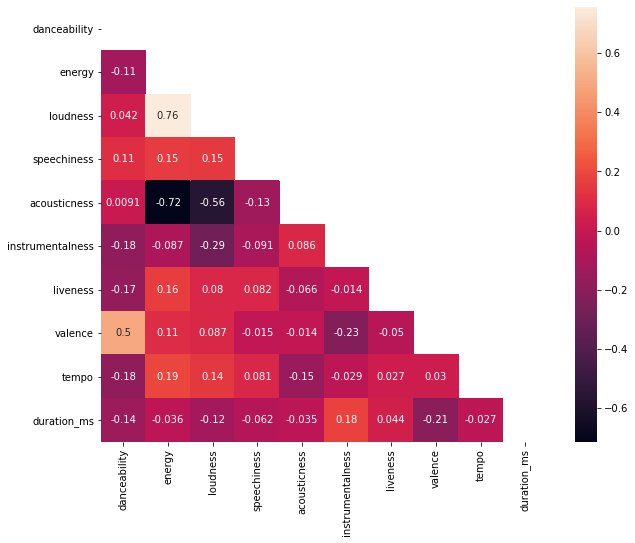

In [118]:
correlations_matrix = num.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

# noticeable:
multicorrelation between loudness vs. energy & acousticness vs. energy
lets check variance inflation factor:

In [119]:
vif = {}
num_vif = num.copy()
num_vif= add_constant(num)

for i in np.arange(num_vif.shape[1]):
    column_name = num_vif.columns[i]
    value = variance_inflation_factor(np.array(num_vif), i)
    vif[column_name] = value
vif  

{'const': 129.89264094493112,
 'danceability': 1.652811238449245,
 'energy': 3.966117180257101,
 'loudness': 2.7948797911197256,
 'speechiness': 1.0812860135157225,
 'acousticness': 2.161494644998475,
 'instrumentalness': 1.2224490095464278,
 'liveness': 1.0684077426946295,
 'valence': 1.5699945917721174,
 'tempo': 1.0969915738052587,
 'duration_ms': 1.0908206553700353}

The vif is pretty low for all numerical features. No action needed for now

## Have a deeper look into numerical features and their impact onto the genre:

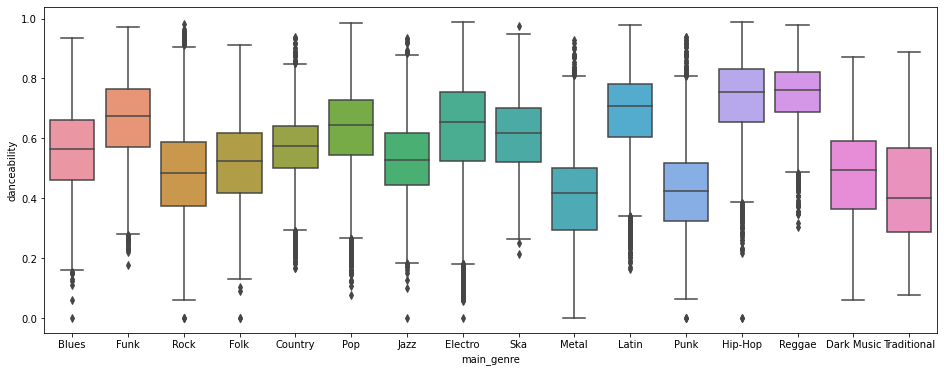

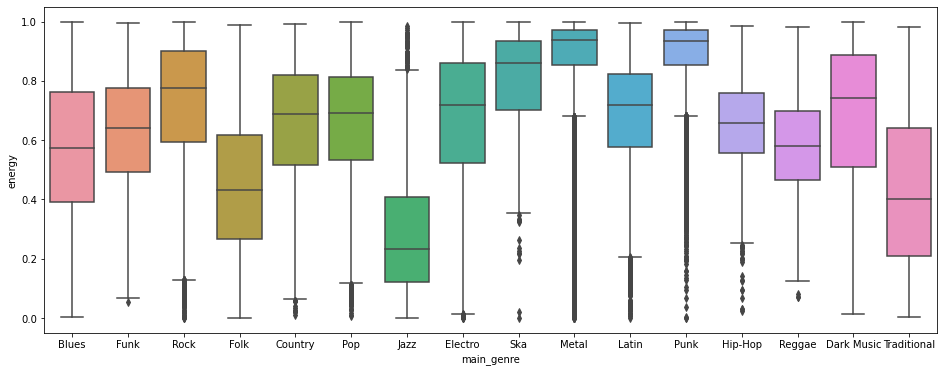

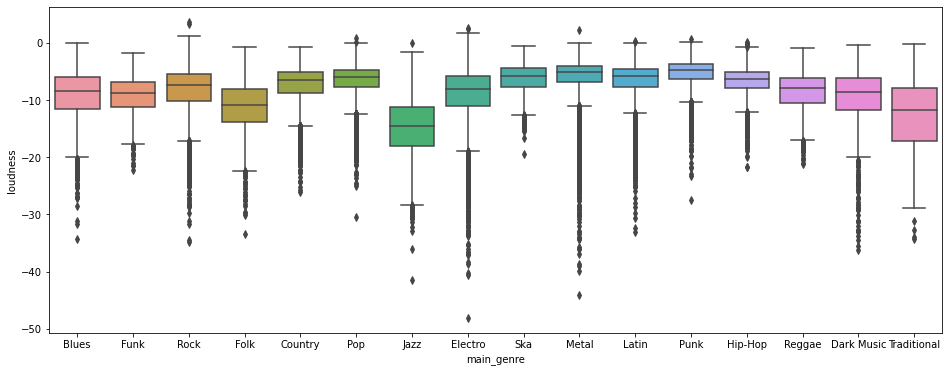

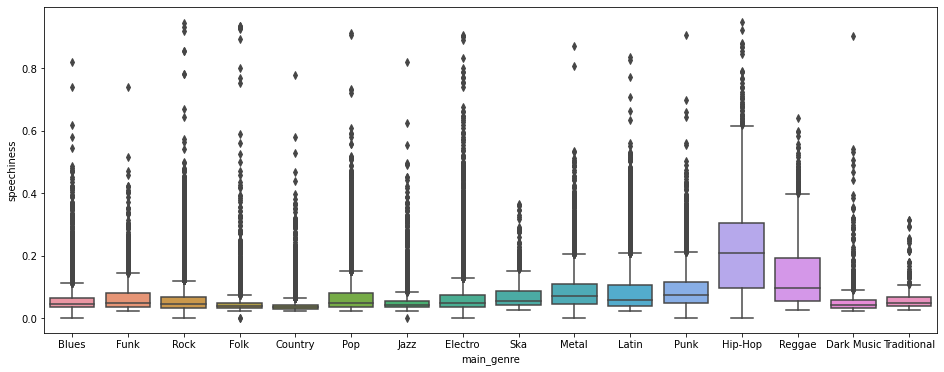

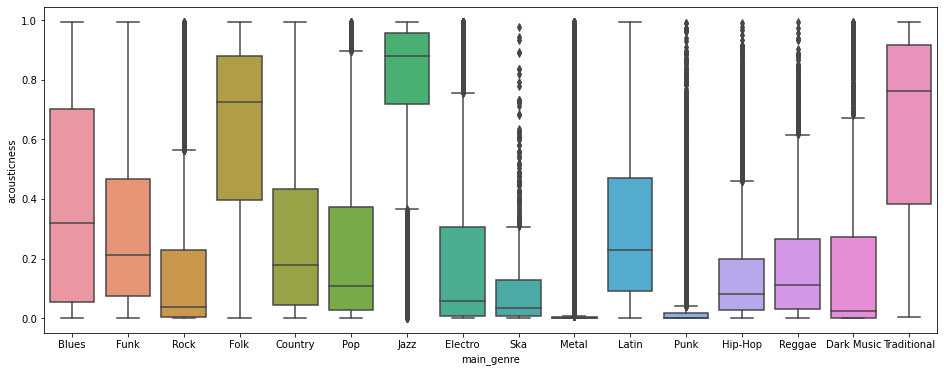

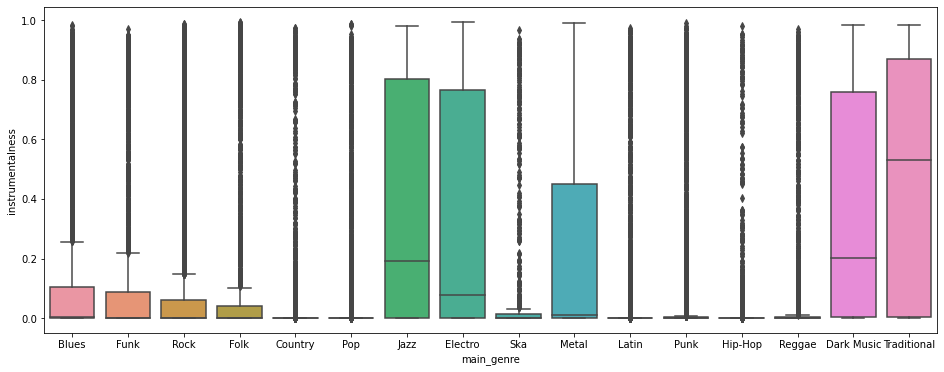

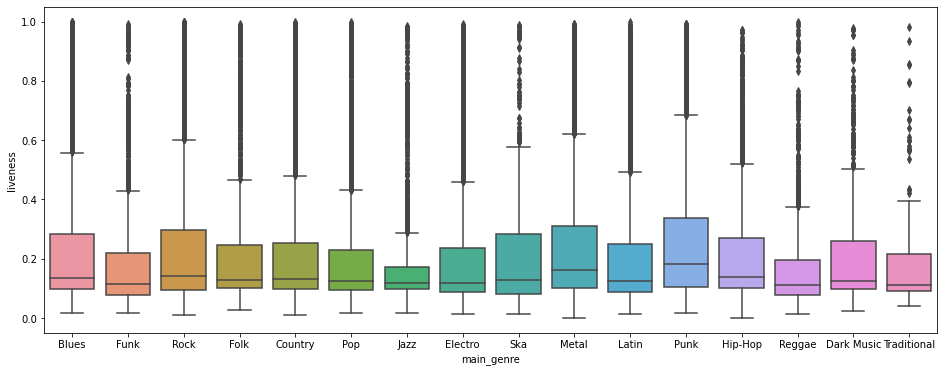

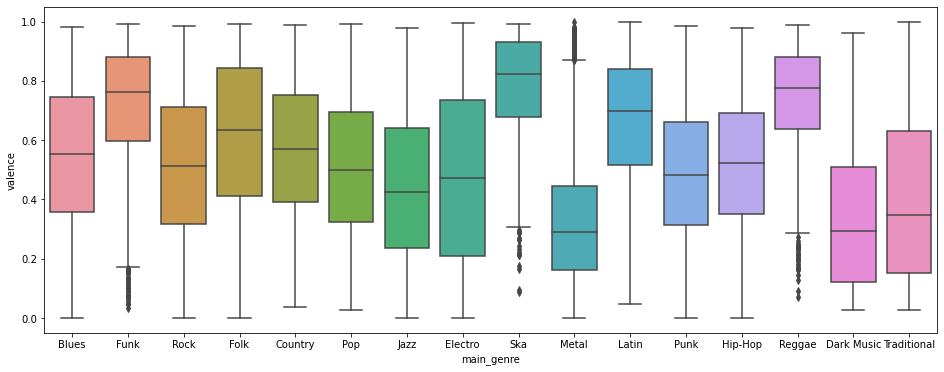

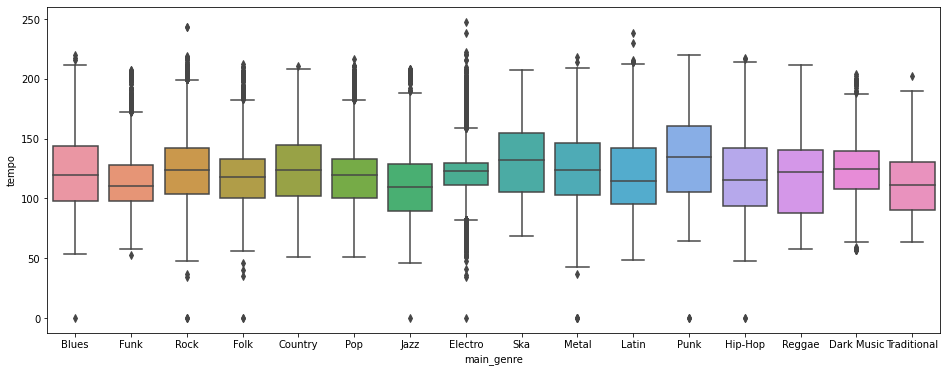

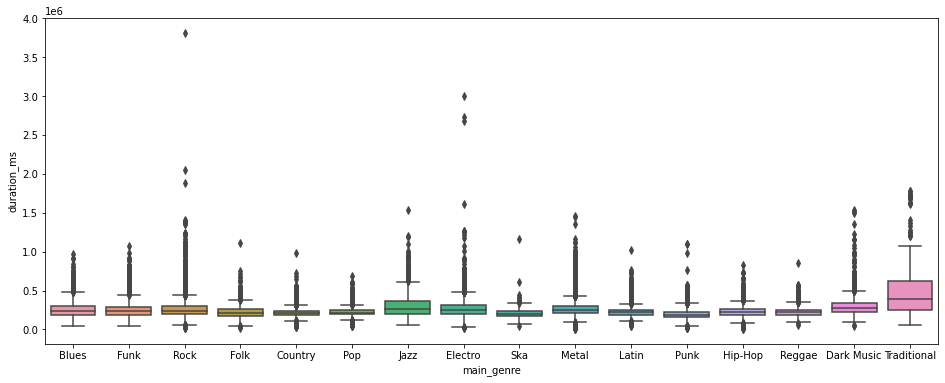

In [120]:
num_concat_target = num.copy()
num_concat_target['main_genre'] = cat['main_genre']

for elements in num_concat_target:
    if elements != 'main_genre':
        fig, ax = plt.subplots(figsize=a4_dims)
        ax = sns.boxplot(x="main_genre", y=elements, data = num_concat_target)
        plt.show()
    else:
        continue

some features (e.g. danceability/energy/instrumentalness) have a hugh impact, while others (e.g. tempo) have a lower impact on the variance among the genres 

removing outliners based on a feature for a specific genre could be a another approach to keep in mind

## EDA -> categoricals

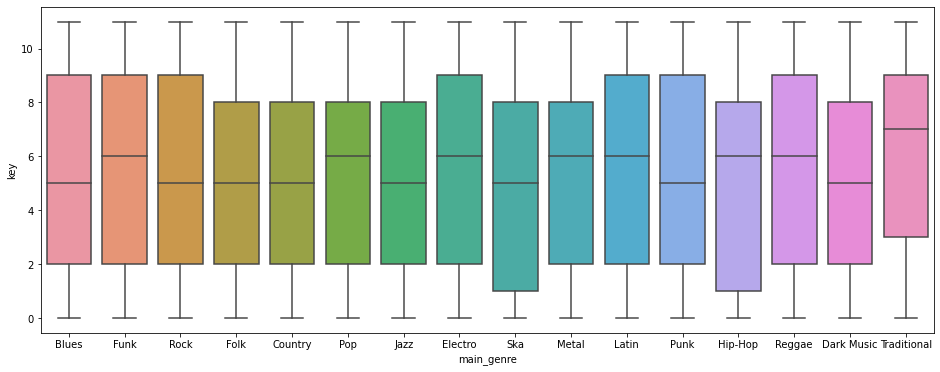

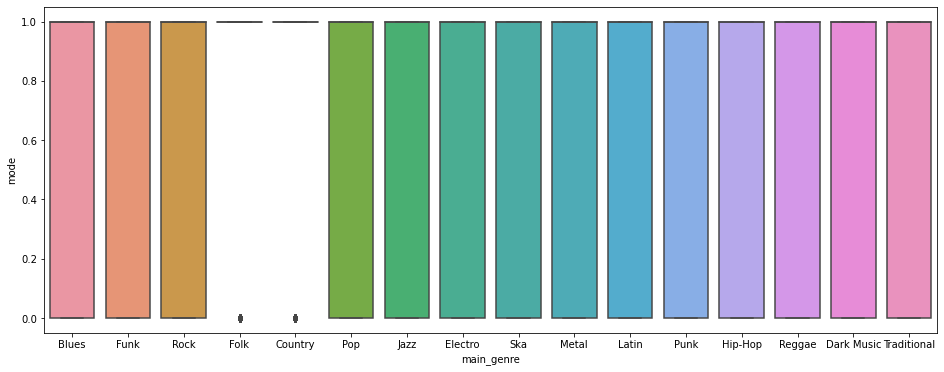

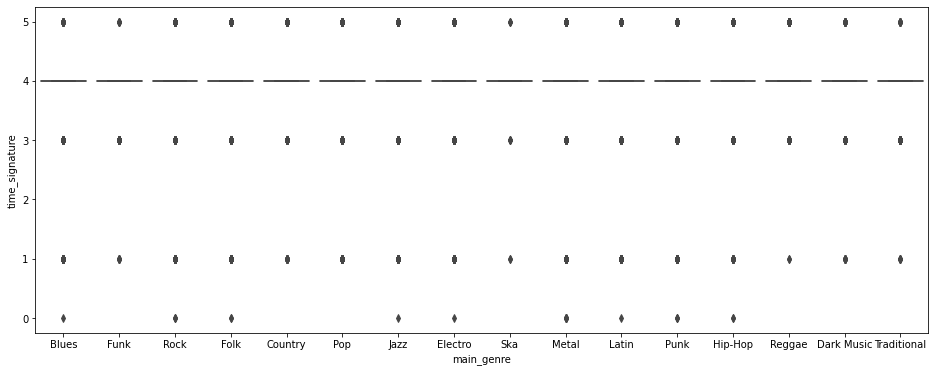

In [121]:
for feature in cat.columns:
    if feature != "main_genre":
        fig, ax = plt.subplots(figsize=a4_dims)
        ax = sns.boxplot(x="main_genre", y = feature, data=cat)
        plt.show()
    else:
        continue

In [122]:
cat["time_signature"].value_counts()

4    109820
3      8223
5      1012
1       663
0        21
Name: time_signature, dtype: int64

In [123]:
cat["mode"].value_counts()

1    76632
0    43107
Name: mode, dtype: int64

In [124]:
cat["key"].value_counts()

7     14293
0     13618
2     12866
9     12818
1     11019
4      9728
5      9440
11     9385
8      7680
6      7650
10     7547
3      3695
Name: key, dtype: int64

merge low frequency values [0,1] to 1 in time signature:

In [125]:
cat['time_signature'] = cat['time_signature'].apply(lambda x: 1 if x < 3 else x)

In [126]:
cat["time_signature"].value_counts()

4.0    109820
3.0      8223
5.0      1012
1.0       684
Name: time_signature, dtype: int64

# check correlation among categorical features with chi2 test:

In [127]:
cat_chi2 = chi2_check(cat.drop(['main_genre'], axis = 1))

#check which pairs of columns have a p value < 0.05, which means a high correlation
cat_chi2[cat_chi2.iloc[:,2]<0.05]

,0,0,0
0,key,mode,0.000000e+00
1,key,time_signature,1.076379e-36


Since mode seems to be a good way to figure out that the song is not of the genre "county,folk", i prefer to keep it. Though lets see how they correlate with each other:

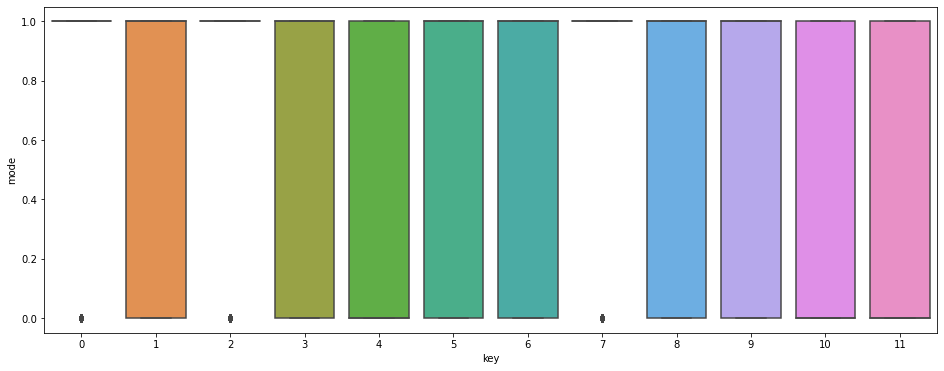

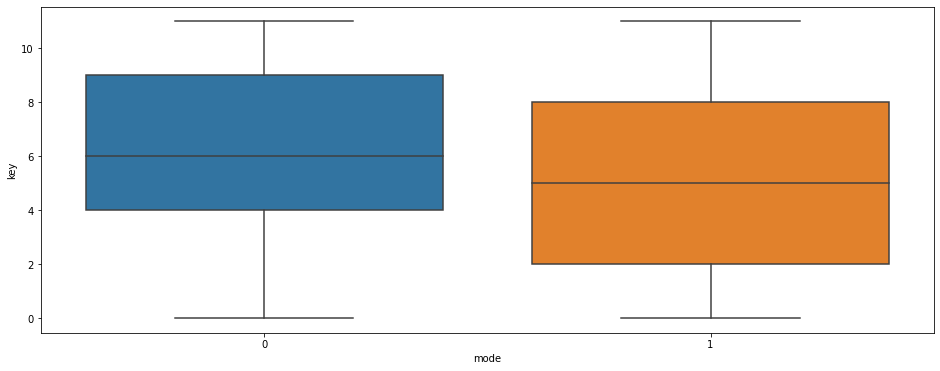

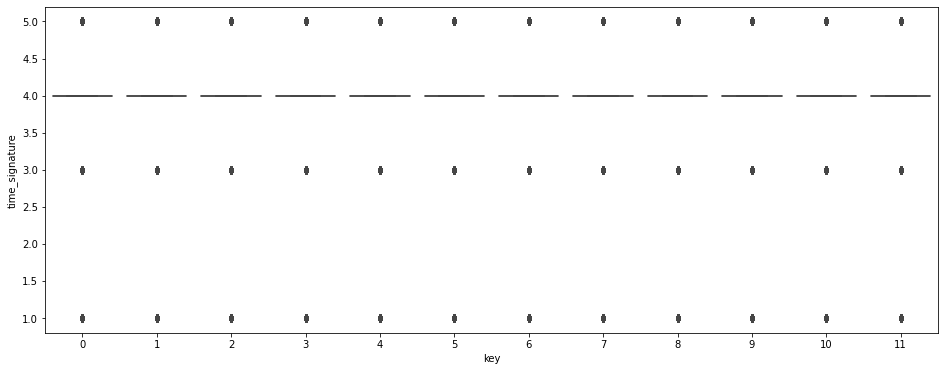

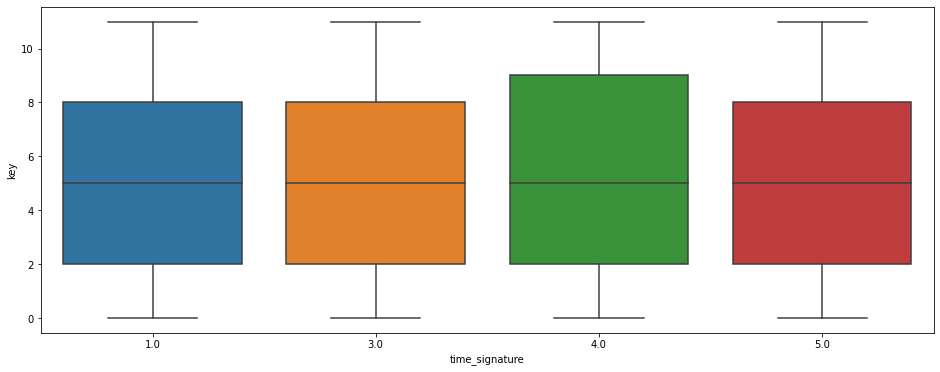

In [128]:
for i in range(cat_chi2[cat_chi2.iloc[:,2]<0.05].shape[0]):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax = sns.boxplot(x=cat_chi2[cat_chi2.iloc[:,2]<0.05].iloc[i,0], y = cat_chi2[cat_chi2.iloc[:,2]<0.05].iloc[i,1], data=cat)
    plt.show()
    fig, ax = plt.subplots(figsize=a4_dims)
    ax = sns.boxplot(x=cat_chi2[cat_chi2.iloc[:,2]<0.05].iloc[i,1], y = cat_chi2[cat_chi2.iloc[:,2]<0.05].iloc[i,0], data=cat)
    plt.show()

It seems that the key value is slightly lower wenn mode equals 1 or the time signature is low, though i stick to all categorical features for now

In [129]:
#check chi-squared values of all pairs of categorical variables and target
cat_target_chi2 = chi2_check(cat)
cat_target_chi2.head()

,0,0,0
0,key,mode,0.000000e+00
1,key,time_signature,1.076379e-36
2,key,main_genre,0.000000e+00
3,mode,time_signature,2.102380e-01
4,mode,main_genre,0.000000e+00


In [130]:
#check which categorical columns are not correlated with target "main_genre" (p>0.1)
cat_target_chi2[(cat_target_chi2.iloc[:,0]=='main_genre')&(cat_target_chi2.iloc[:,2]>0.1)]

,0,0,0


the results shows that the categorical values do have an impact on the genre

## EDA -> categorical vs numerical:

In [131]:
df_cat_no_target = cat.drop(columns="main_genre",axis=1)

In [132]:
df_cat_no_target.head()

,key,mode,time_signature
0,0,1,4.0
1,11,1,4.0
2,2,1,4.0
3,0,1,4.0
4,4,1,4.0


# Mode vs num:

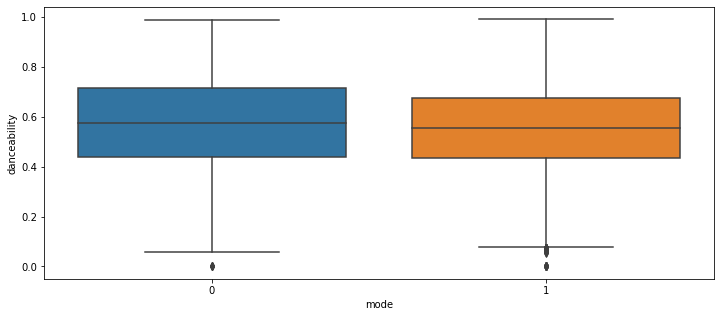

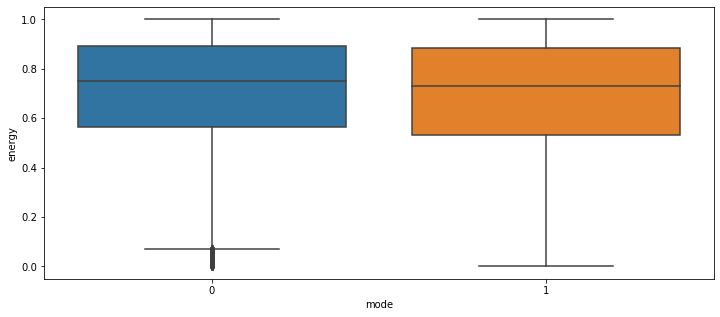

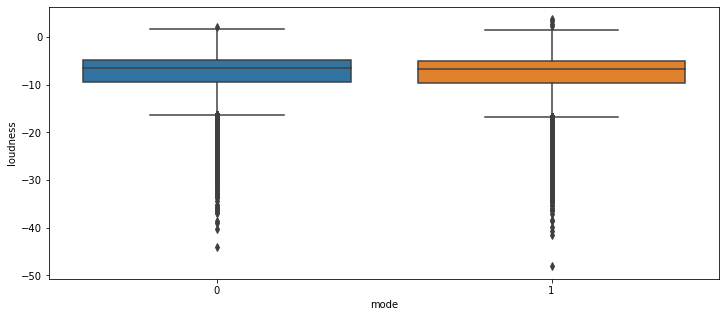

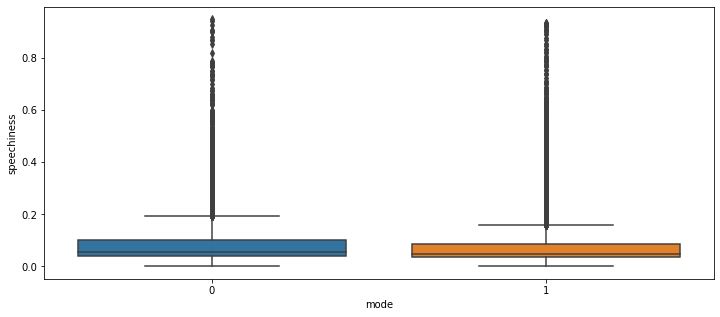

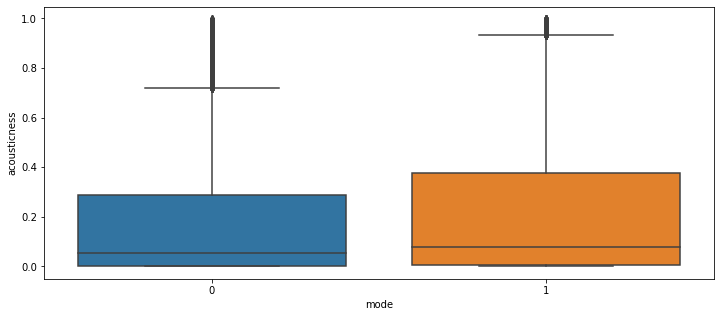

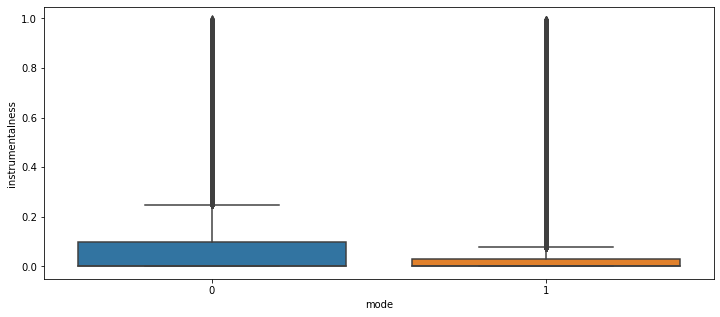

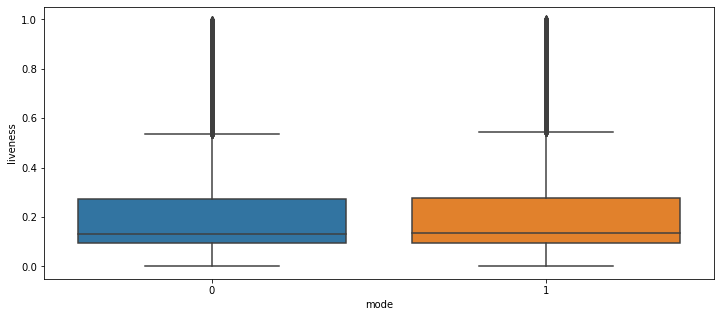

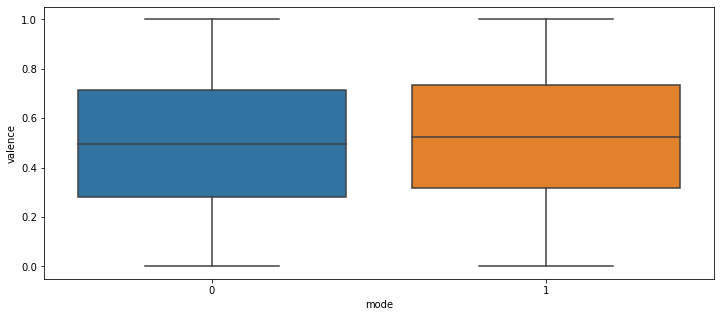

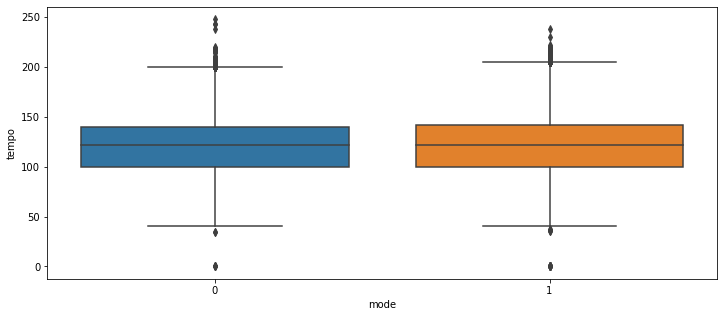

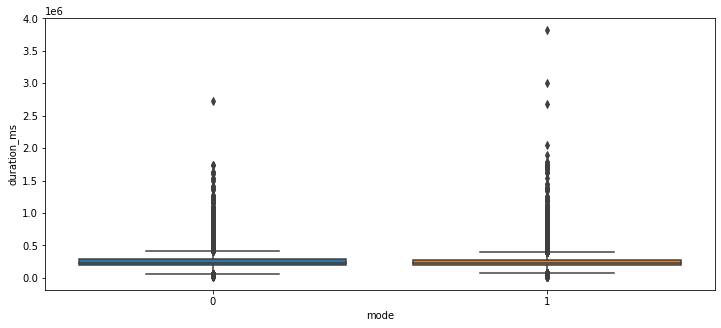

In [133]:
for feature in num.columns:
    fig, ax = plt.subplots(figsize=[12,5])
    ax = sns.boxplot(x="mode", y=feature, data = df)
    plt.show()

# key vs num:

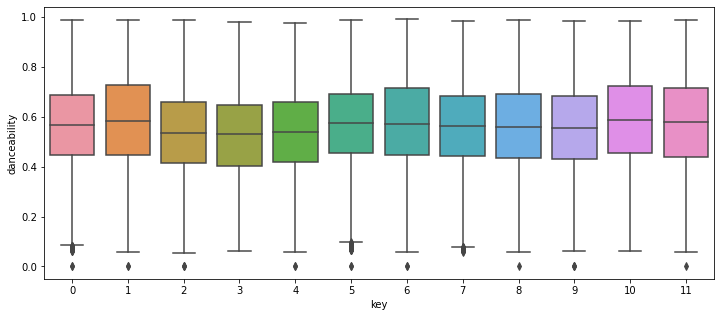

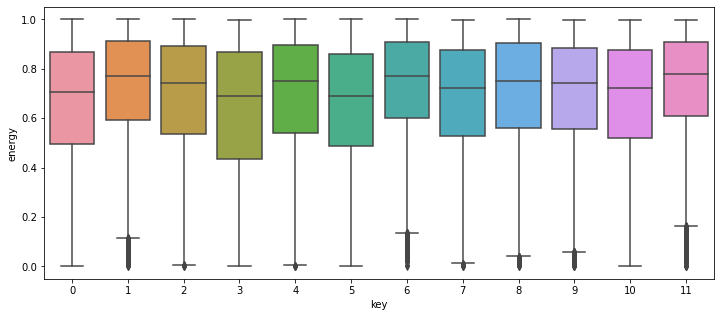

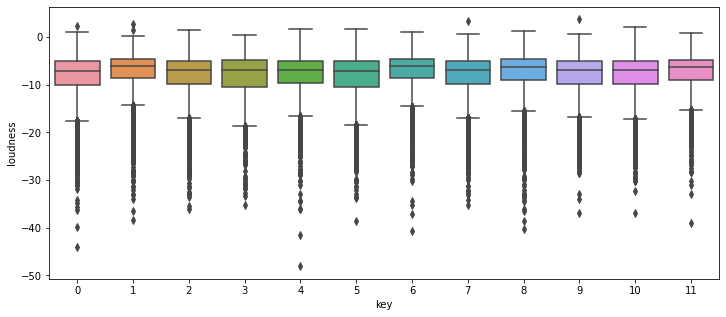

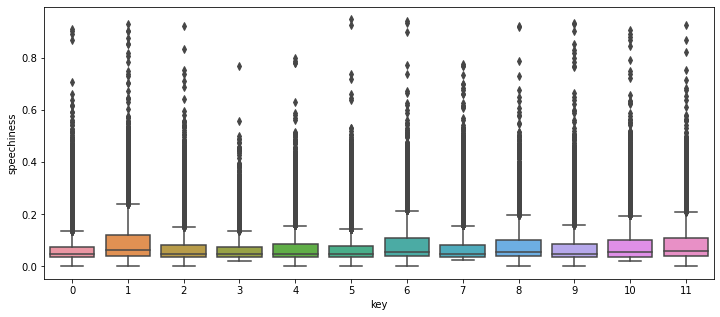

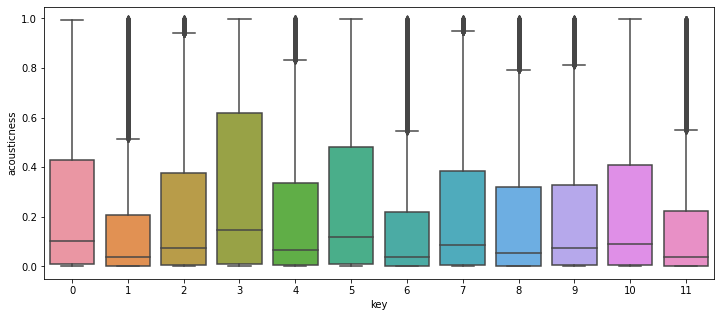

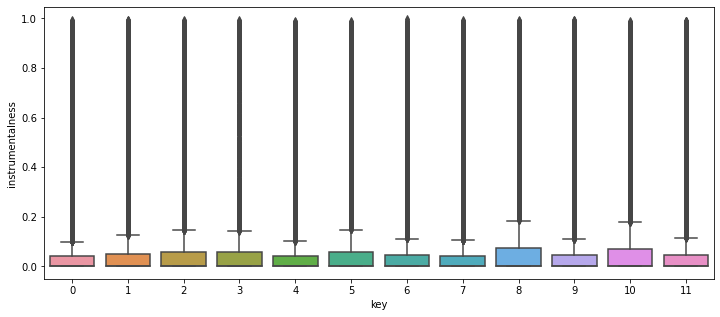

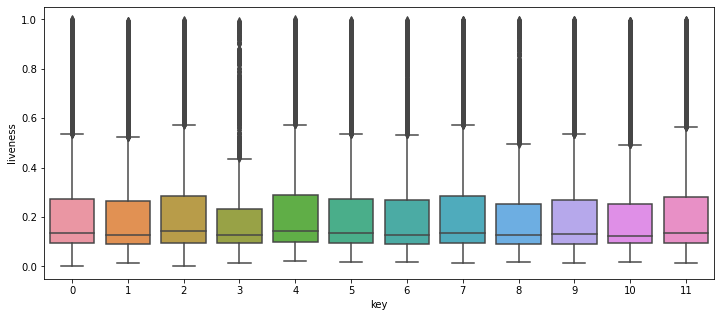

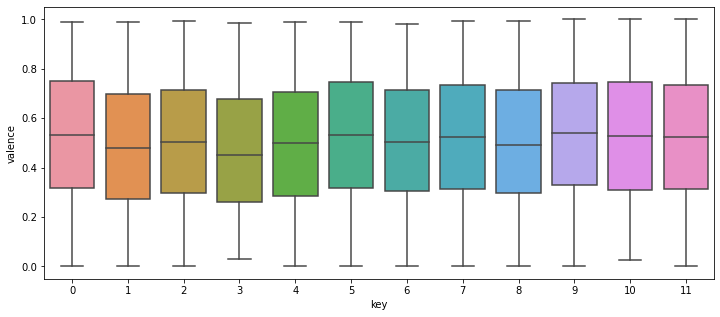

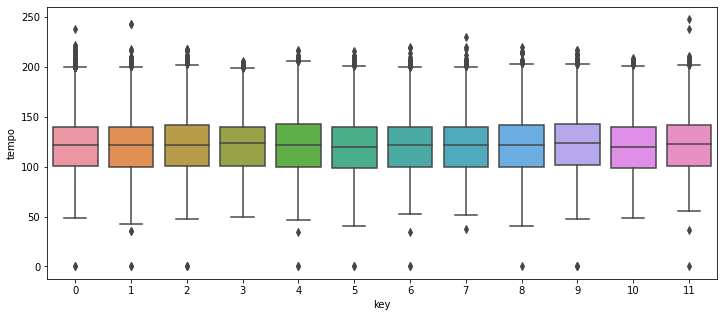

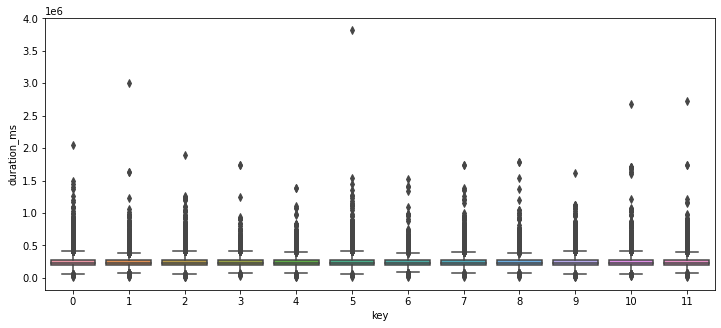

In [134]:
for feature in num.columns:
    fig, ax = plt.subplots(figsize=[12,5])
    ax = sns.boxplot(x="key", y=feature, data = df)
    plt.show()

# time_signature vs num:

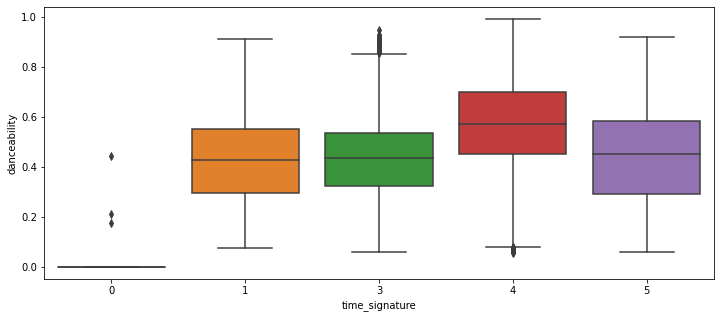

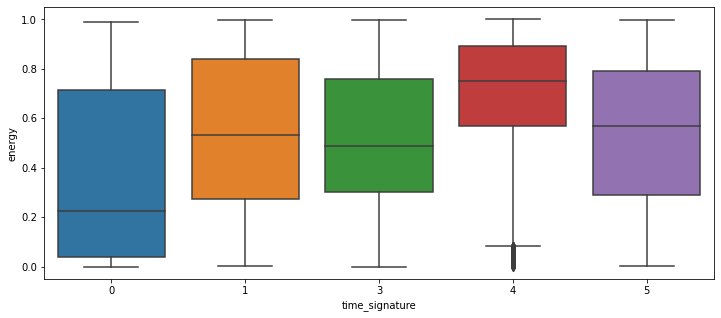

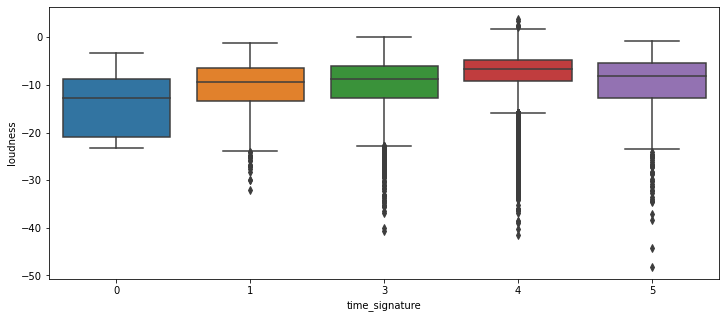

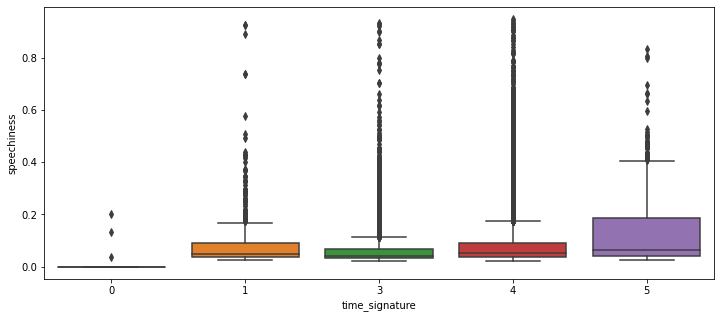

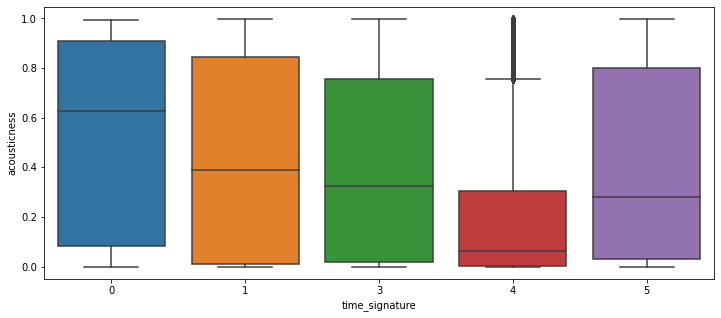

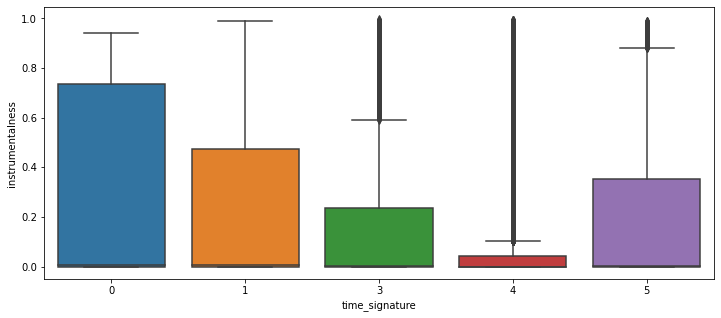

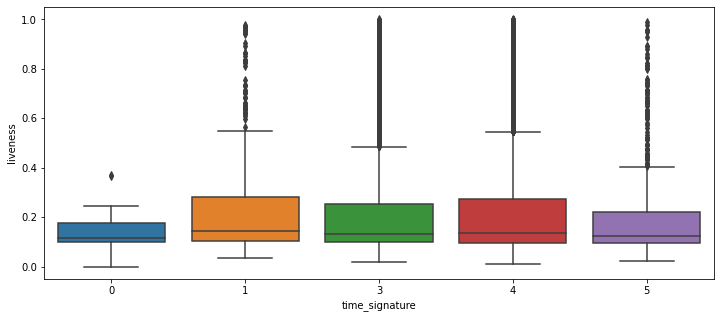

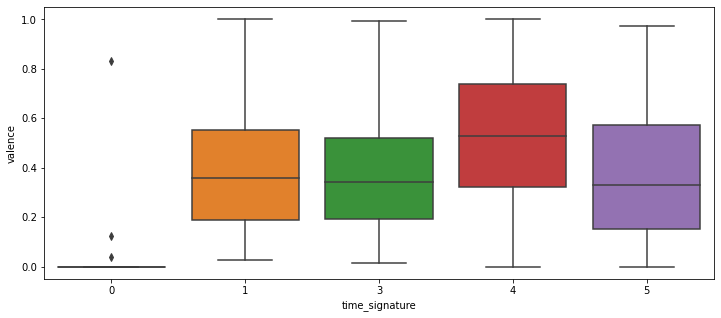

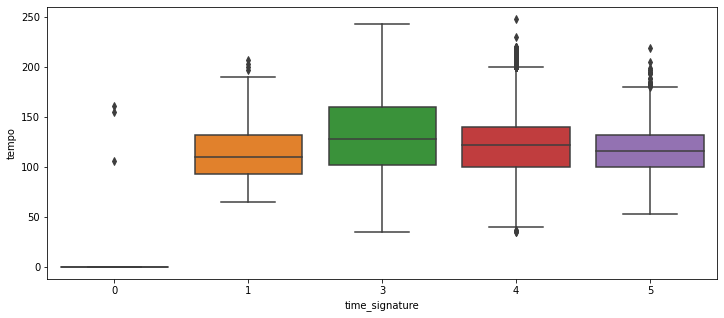

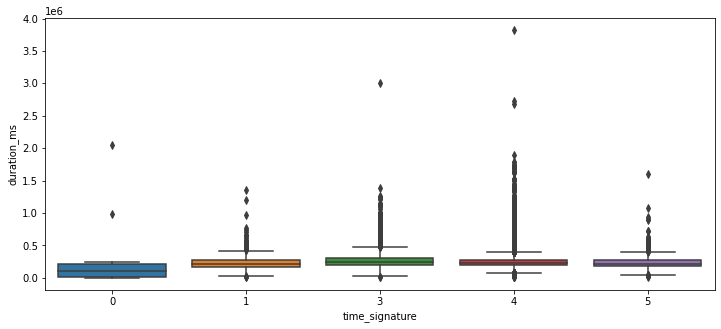

In [135]:
for feature in num.columns:
    fig, ax = plt.subplots(figsize=[12,5])
    ax = sns.boxplot(x="time_signature", y=feature, data = df)
    plt.show()

Estimation: time_signature among the categoricals is most noticable correlated with some numerical features. Will keep that in mind after outliners had been removed:

# Removing outliners:

danceability


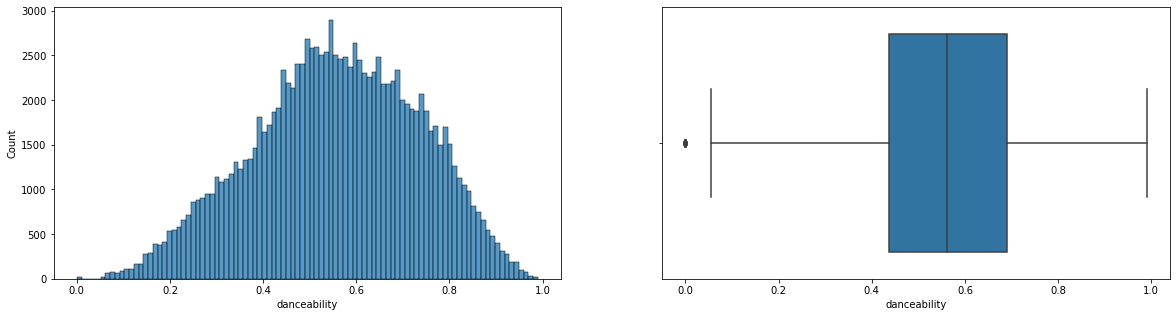

energy


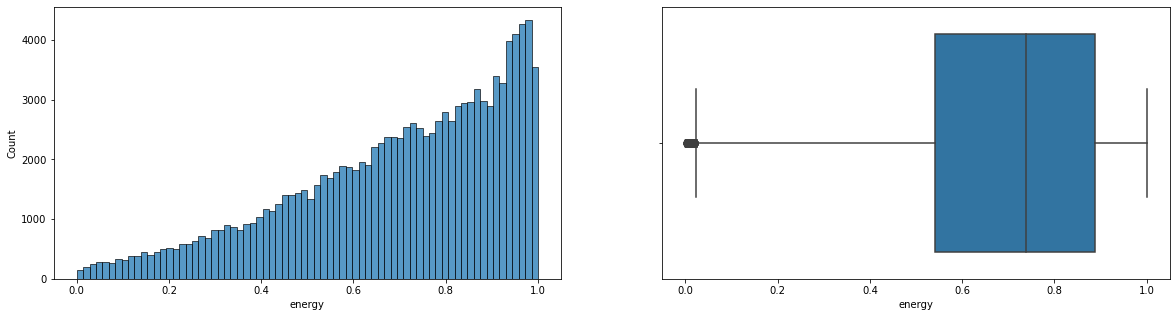

loudness


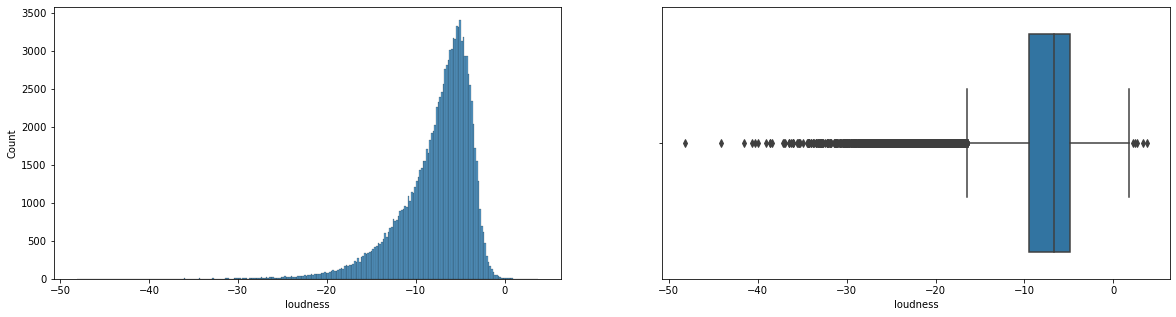

speechiness


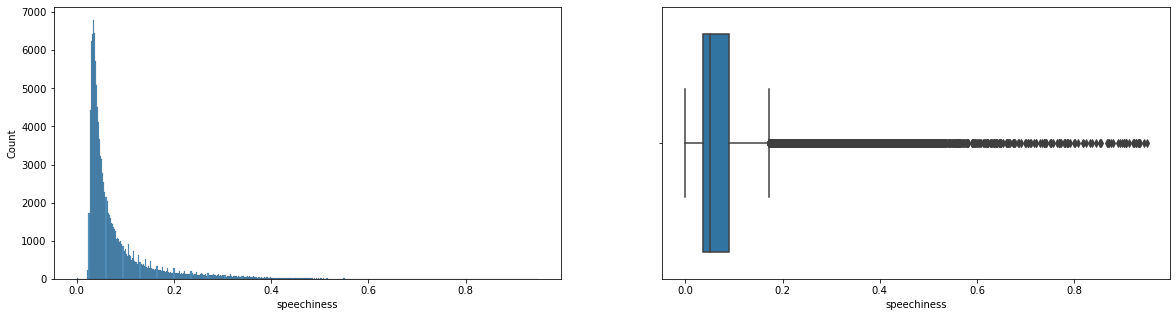

acousticness


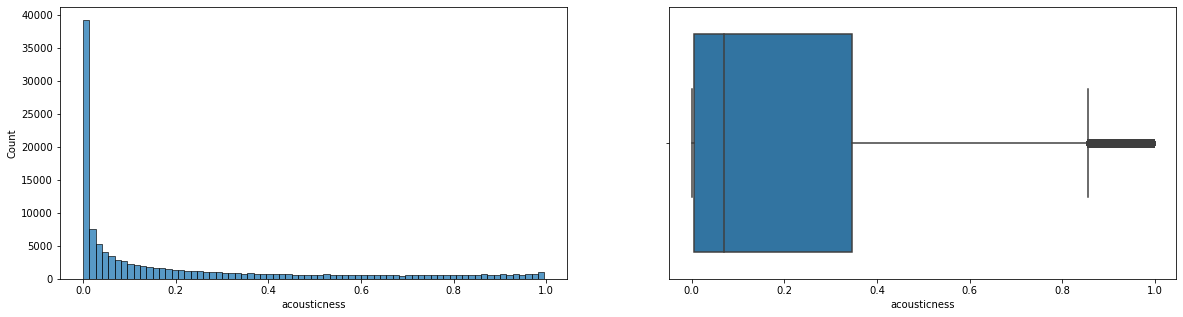

instrumentalness


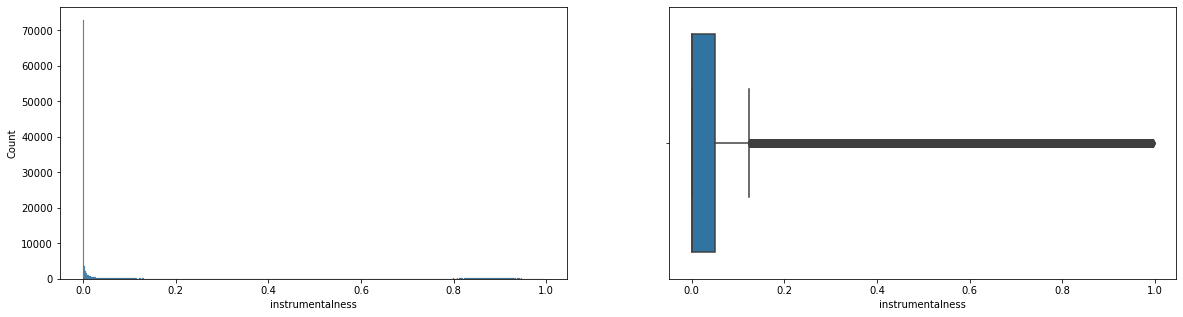

liveness


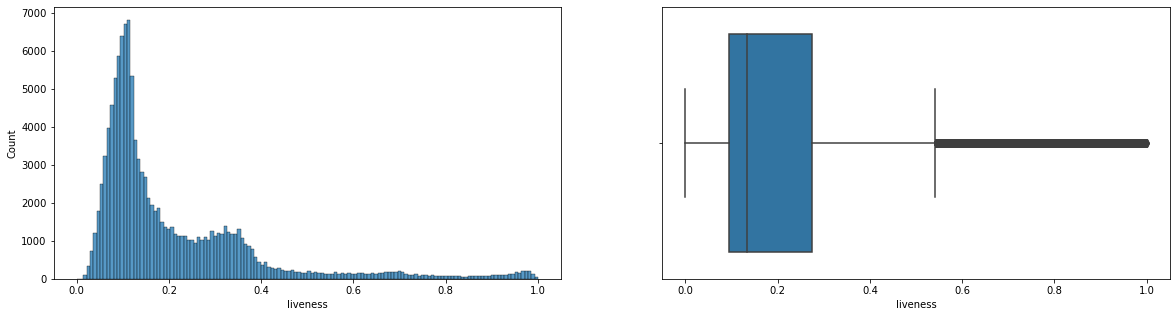

valence


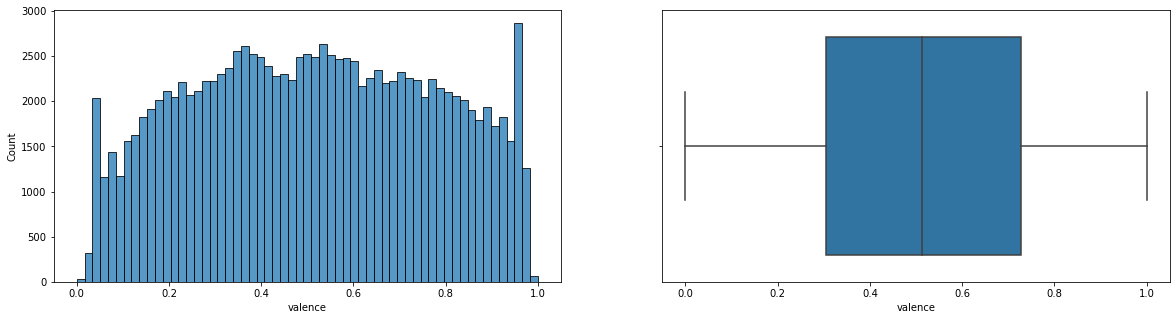

tempo


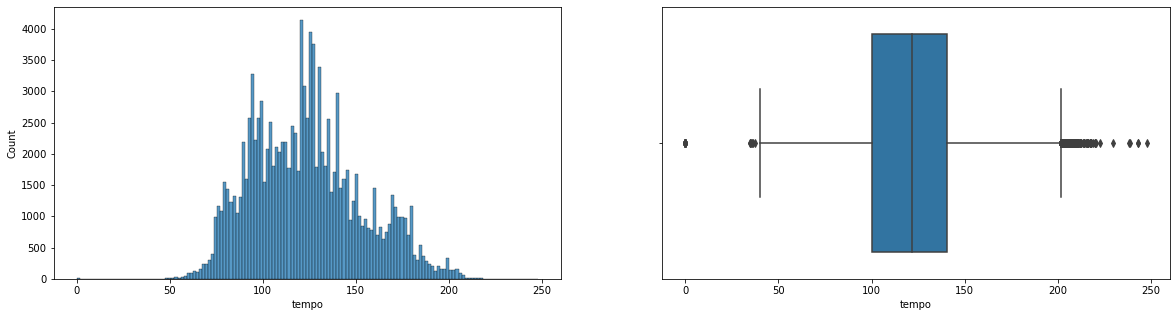

duration_ms


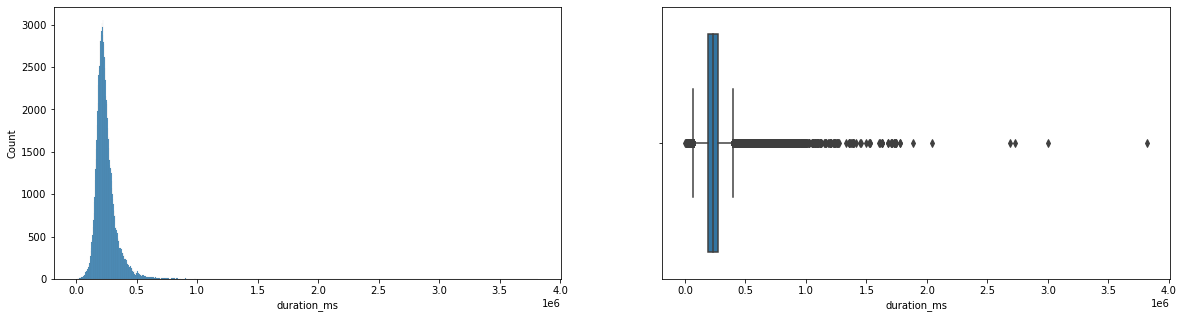

In [136]:
for feature in df.select_dtypes(include=np.number).columns:
    fig,(ax1, ax2) = plt.subplots(1,2,figsize = [20, 5]) 
    #plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
    print(feature)
    sns.histplot(df[feature], ax=ax1)
    sns.boxplot(df[feature], ax=ax2)
    plt.show()

noticeable: loudness, speechiness, instrumentalness, duration_ms

additional (maybe): danceability, tempo, instrumentalness, liveness

go with duration_ms first, since its most likely the biggest impact due to podcast/books etc.

In [158]:
#Concatenate num and cat
df = pd.concat([cat, num], axis =1)

In [159]:
df_outliners = df.copy()

In [160]:
print(df_outliners.shape[0]) 
df_outliners = remove_outliers(df_outliners, 'duration_ms', 2)
print(df_outliners.shape[0]) 
df_outliners = remove_outliers(df_outliners, 'loudness', 3)
print(df_outliners.shape[0]) 
df_outliners = remove_outliers(df_outliners, 'speechiness', 4)
print(df_outliners.shape[0]) 
df_outliners = remove_outliers(df_outliners, 'tempo', 2)
print(df_outliners.shape[0]) 
df_outliners = remove_outliers(df_outliners, 'danceability', 3)

119739
115812
115194
112027
112013


time_signature


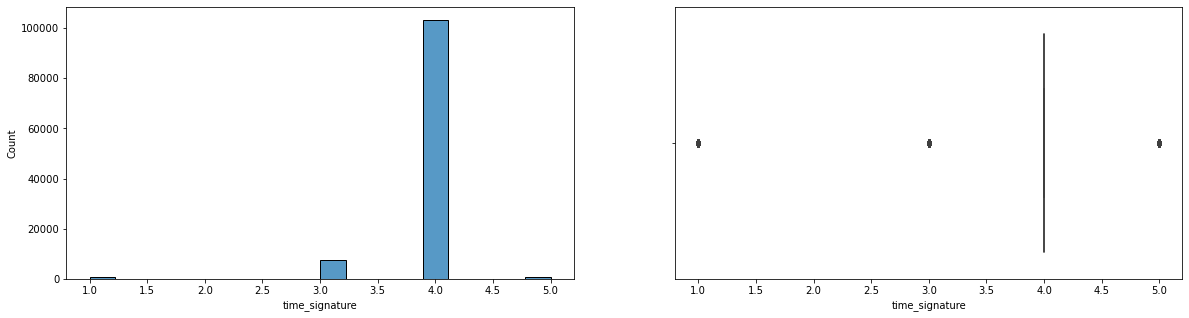

danceability


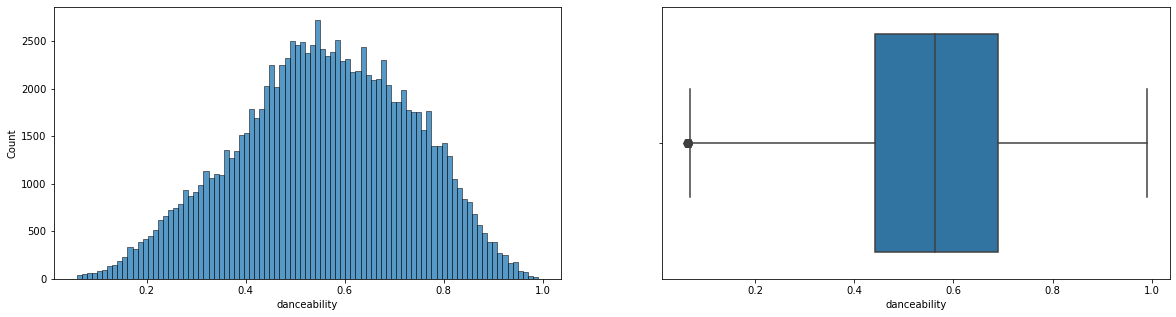

energy


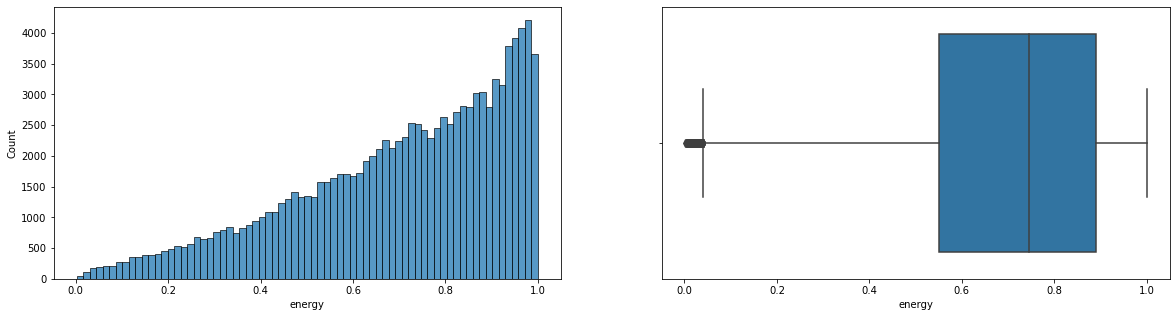

loudness


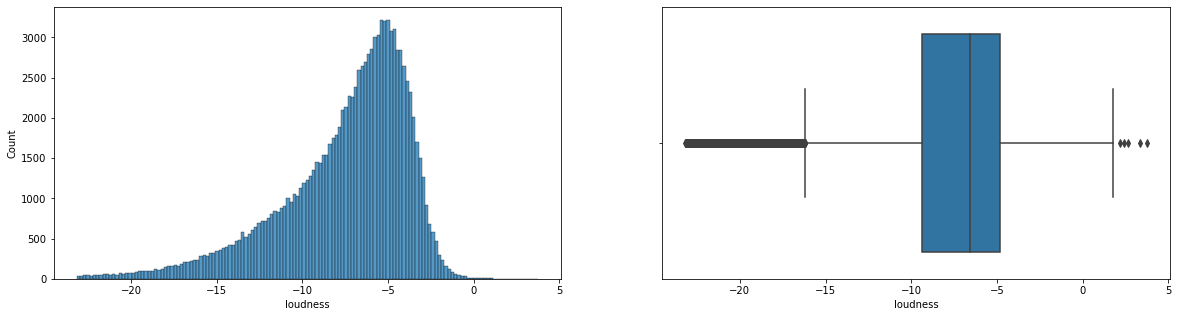

speechiness


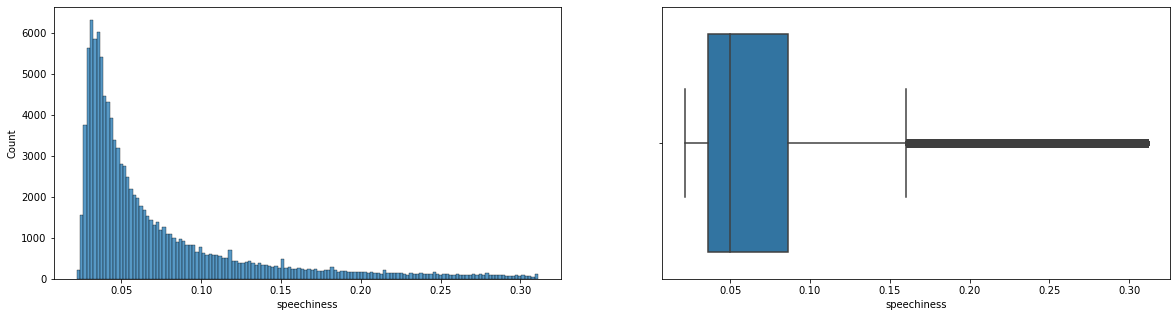

acousticness


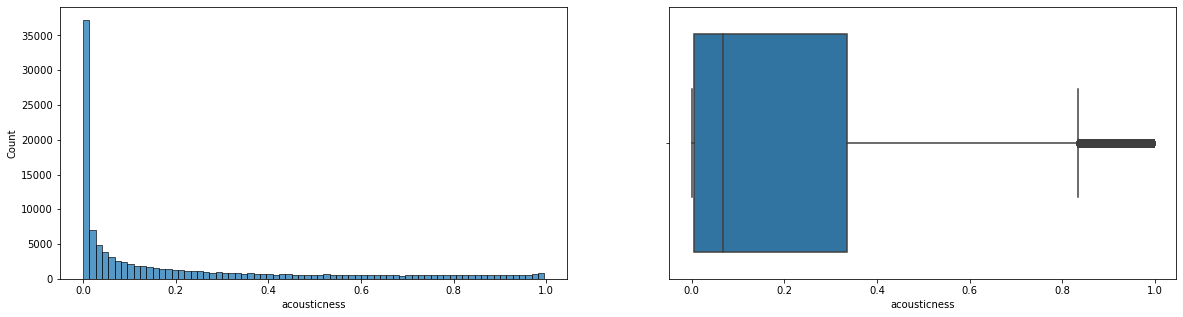

instrumentalness


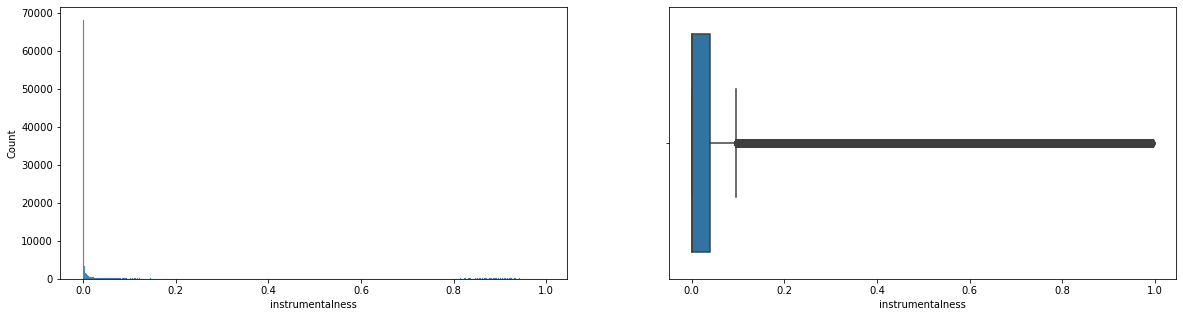

liveness


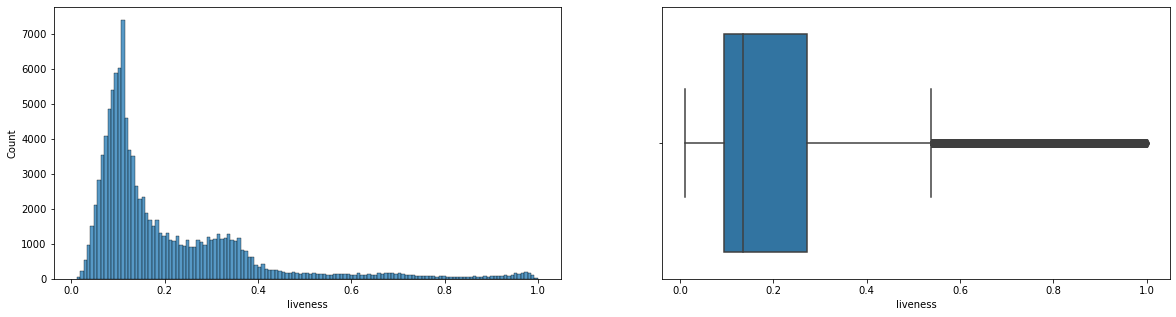

valence


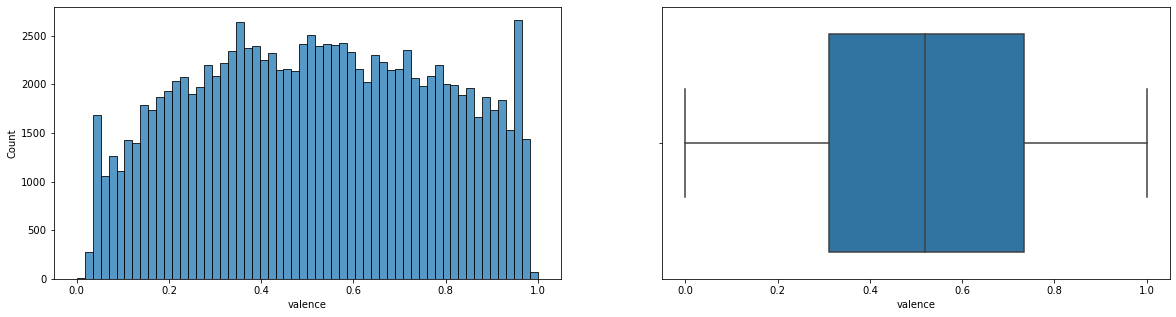

tempo


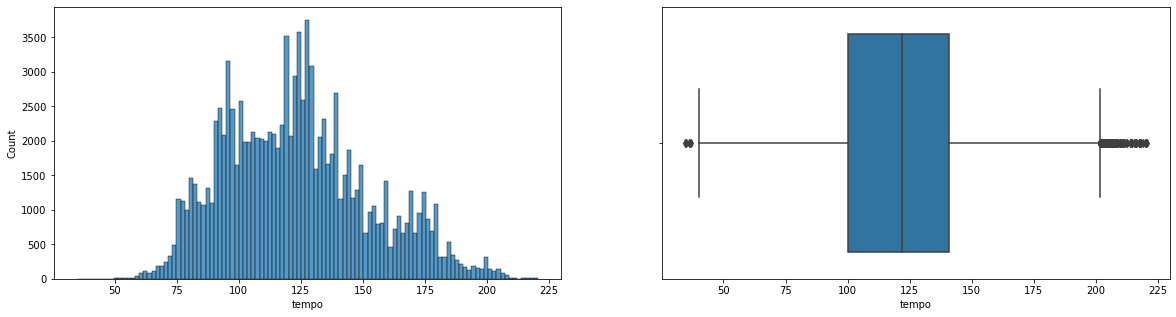

duration_ms


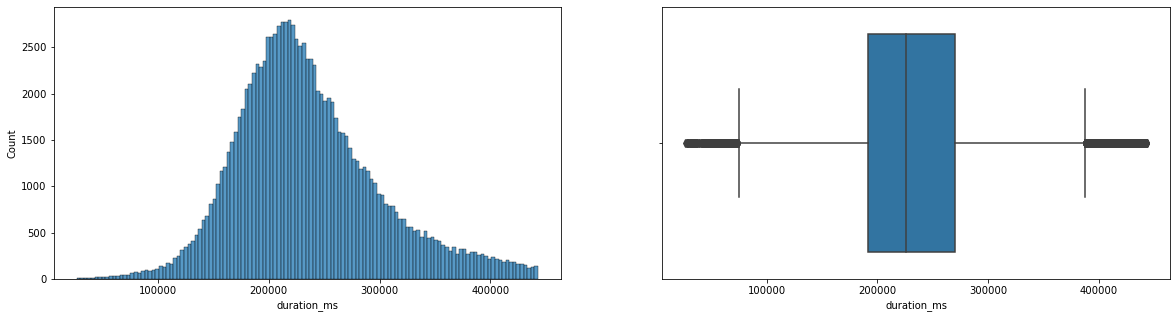

In [161]:
# Check results:
for feature in df_outliners.select_dtypes(include=np.number).columns:
    fig,(ax1, ax2) = plt.subplots(1,2,figsize = [20, 5]) 
    #plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
    sns.histplot(df_outliners[feature], ax=ax1)
    sns.boxplot(df_outliners[feature], ax=ax2)
    plt.show()

In [148]:
#removed:
print("songs removed: " + str((1-112013/119739)*100) + "%")

songs removed: 6.452367232063072%


In [162]:
df = df_outliners.copy()

# Handling data imbalance:

Since the amount of songs is hugh and the amount of features is less than 15, i will go for a simple approach on handling the data imbalance by random choice from the high frequency genres to flatten the variation among the genres:

In [172]:
df["main_genre"].value_counts()

Rock           22312
Metal          14145
Electro        13158
Pop            11122
Latin          10620
Country         9395
Punk            7543
Hip-Hop         5317
Blues           4642
Jazz            3045
Folk            3027
Reggae          2832
Funk            2385
Dark Music      1345
Ska              927
Traditional      198
Name: main_genre, dtype: int64

In [196]:
df["main_genre"].unique()

array(['Blues', 'Funk', 'Rock', 'Folk', 'Country', 'Pop', 'Jazz',
       'Electro', 'Ska', 'Metal', 'Latin', 'Punk', 'Hip-Hop', 'Reggae',
       'Dark Music', 'Traditional'], dtype=object)

as a first approach i will take 1000 songs, then only 1 genres is underrepresented: (traditional)

In [202]:
choice_labels = list(df["main_genre"].unique())
choice_labels.remove("Traditional")
choice_labels.remove("Ska")
amount = 1000
# remained_df = df[(df[n] == "Jazz") | (df[n] == "Folk") | (df[n] == "Reggae") 
#                        | (df[n] == "Funk") | (df[n] == "Dark Music") | (df[n] == "Ska") 
#                        | (df[n] == "Traditional")]

remained_df = df[(df["main_genre"] == "Traditional") | (df["main_genre"] == "Ska")]

In [203]:
for genre in choice_labels:
    genre_df = df[df["main_genre"]==genre]
    resampled_ind=np.random.choice(genre_df.index,amount,replace=False)
    remained_df = pd.concat([remained_df,genre_df.loc[resampled_ind]], axis=0)

In [210]:
df_bal = remained_df.copy()

In [205]:
df_bal.shape

(15125, 14)

In [208]:
df_bal.head()

,key,mode,time_signature,main_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
459,3,0,4.0,Ska,0.547,0.853,-2.490,0.0355,0.200000,0.000003,0.2540,0.723,137.561,219293.0
2982,10,0,4.0,Ska,0.621,0.397,-9.530,0.0484,0.006990,0.765000,0.0796,0.688,147.380,304000.0
5758,5,0,3.0,Traditional,0.525,0.536,-7.078,0.0411,0.494000,0.000115,0.1090,0.298,167.963,359133.0
9364,0,1,4.0,Traditional,0.710,0.928,-3.793,0.0783,0.225000,0.000016,0.4320,0.896,130.019,313520.0
9470,0,0,4.0,Ska,0.759,0.461,-11.901,0.1350,0.000119,0.000128,0.0943,0.693,148.936,240160.0


In [206]:
df_bal["main_genre"].value_counts()

Blues          1000
Electro        1000
Rock           1000
Punk           1000
Dark Music     1000
Reggae         1000
Funk           1000
Jazz           1000
Pop            1000
Hip-Hop        1000
Latin          1000
Country        1000
Metal          1000
Folk           1000
Ska             927
Traditional     198
Name: main_genre, dtype: int64

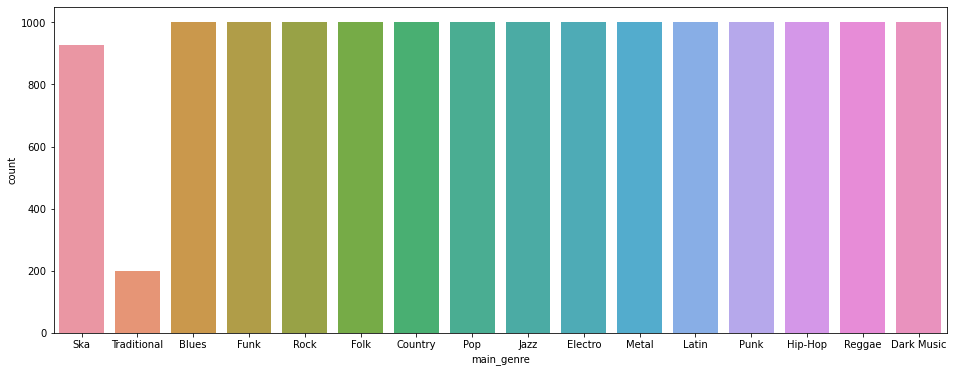

In [207]:
a4_dims = (16, 6)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.countplot(ax = ax, x = "main_genre", data = df_bal)

In [238]:
df_bal.head()

,key,mode,time_signature,main_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,3,0,4.0,Ska,0.547,0.853,-2.490,0.0355,0.200000,0.000003,0.2540,0.723,137.561,219293.0
1,10,0,4.0,Ska,0.621,0.397,-9.530,0.0484,0.006990,0.765000,0.0796,0.688,147.380,304000.0
2,5,0,3.0,Traditional,0.525,0.536,-7.078,0.0411,0.494000,0.000115,0.1090,0.298,167.963,359133.0
3,0,1,4.0,Traditional,0.710,0.928,-3.793,0.0783,0.225000,0.000016,0.4320,0.896,130.019,313520.0
4,0,0,4.0,Ska,0.759,0.461,-11.901,0.1350,0.000119,0.000128,0.0943,0.693,148.936,240160.0


In [241]:
df_bal = df_bal.sample(frac=1)

In [242]:
df_bal = df_bal.reset_index(drop=True)

In [243]:
df_bal.head()

,key,mode,time_signature,main_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,5,0,4.0,Jazz,0.393,0.508,-9.421,0.0640,0.1410,0.876000,0.116,0.603,93.054,430053.0
1,11,0,4.0,Dark Music,0.870,0.488,-5.034,0.0465,0.0307,0.797000,0.652,0.548,116.586,198546.0
2,10,0,4.0,Jazz,0.717,0.554,-8.379,0.0768,0.6540,0.000004,0.101,0.610,150.143,197160.0
3,11,0,4.0,Hip-Hop,0.945,0.582,-8.357,0.0719,0.1140,0.000000,0.103,0.907,108.025,168906.0
4,11,0,4.0,Hip-Hop,0.614,0.682,-4.117,0.1020,0.3870,0.000000,0.134,0.566,100.202,169853.0


# Transforming and Encoding:

Splitting data again for transforming and label encoding:

In [269]:
cat_columns = []
num_columns = []
threshold = 20
for name in df_bal.columns:
    if len(df_bal[name].unique()) > threshold:
        num_columns.append(name)
    else:
        cat_columns.append(name)

In [245]:
num = df_bal[num_columns]
num.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.393,0.508,-9.421,0.0640,0.1410,0.876000,0.116,0.603,93.054,430053.0
1,0.870,0.488,-5.034,0.0465,0.0307,0.797000,0.652,0.548,116.586,198546.0
2,0.717,0.554,-8.379,0.0768,0.6540,0.000004,0.101,0.610,150.143,197160.0
3,0.945,0.582,-8.357,0.0719,0.1140,0.000000,0.103,0.907,108.025,168906.0
4,0.614,0.682,-4.117,0.1020,0.3870,0.000000,0.134,0.566,100.202,169853.0


In [304]:
cat = df_bal[cat_columns]
cat.head()

,key,mode,time_signature,main_genre
0,5,0,4.0,Jazz
1,11,0,4.0,Dark Music
2,10,0,4.0,Jazz
3,11,0,4.0,Hip-Hop
4,11,0,4.0,Hip-Hop


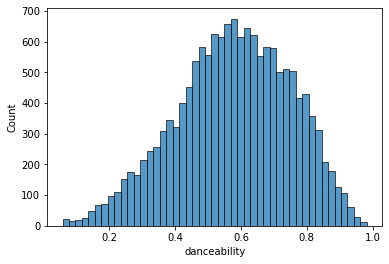

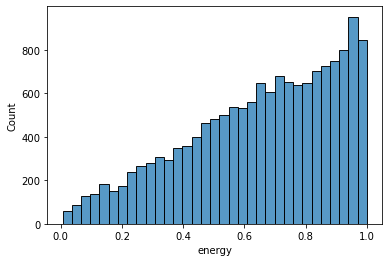

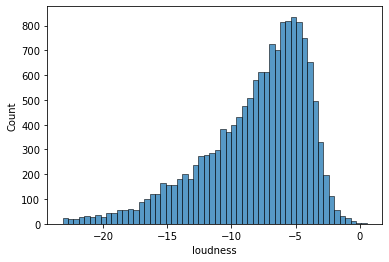

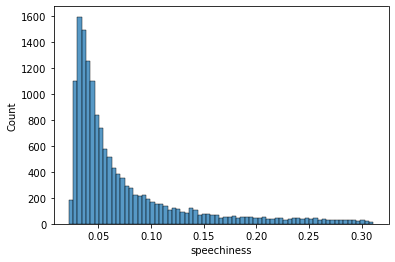

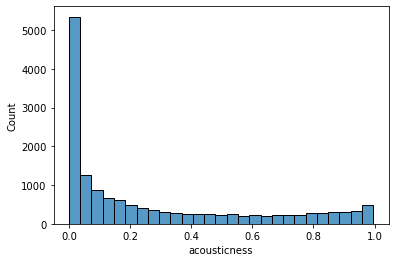

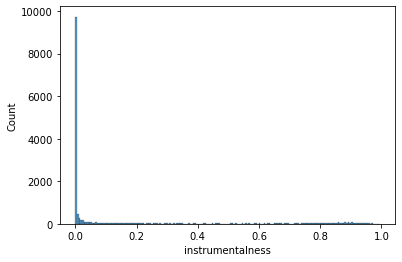

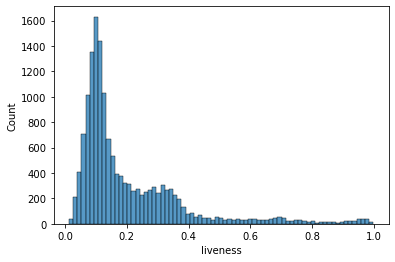

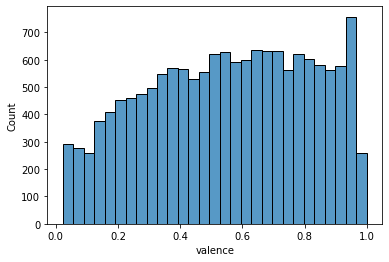

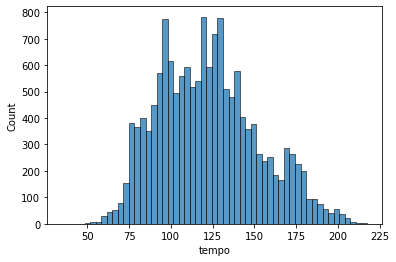

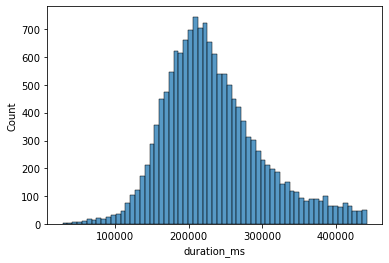

In [247]:
for name in num.columns:
    sns.histplot(x=name, data=num)
    plt.show()

noticeable: try transform: speechiness, acousticness, instrumentalness

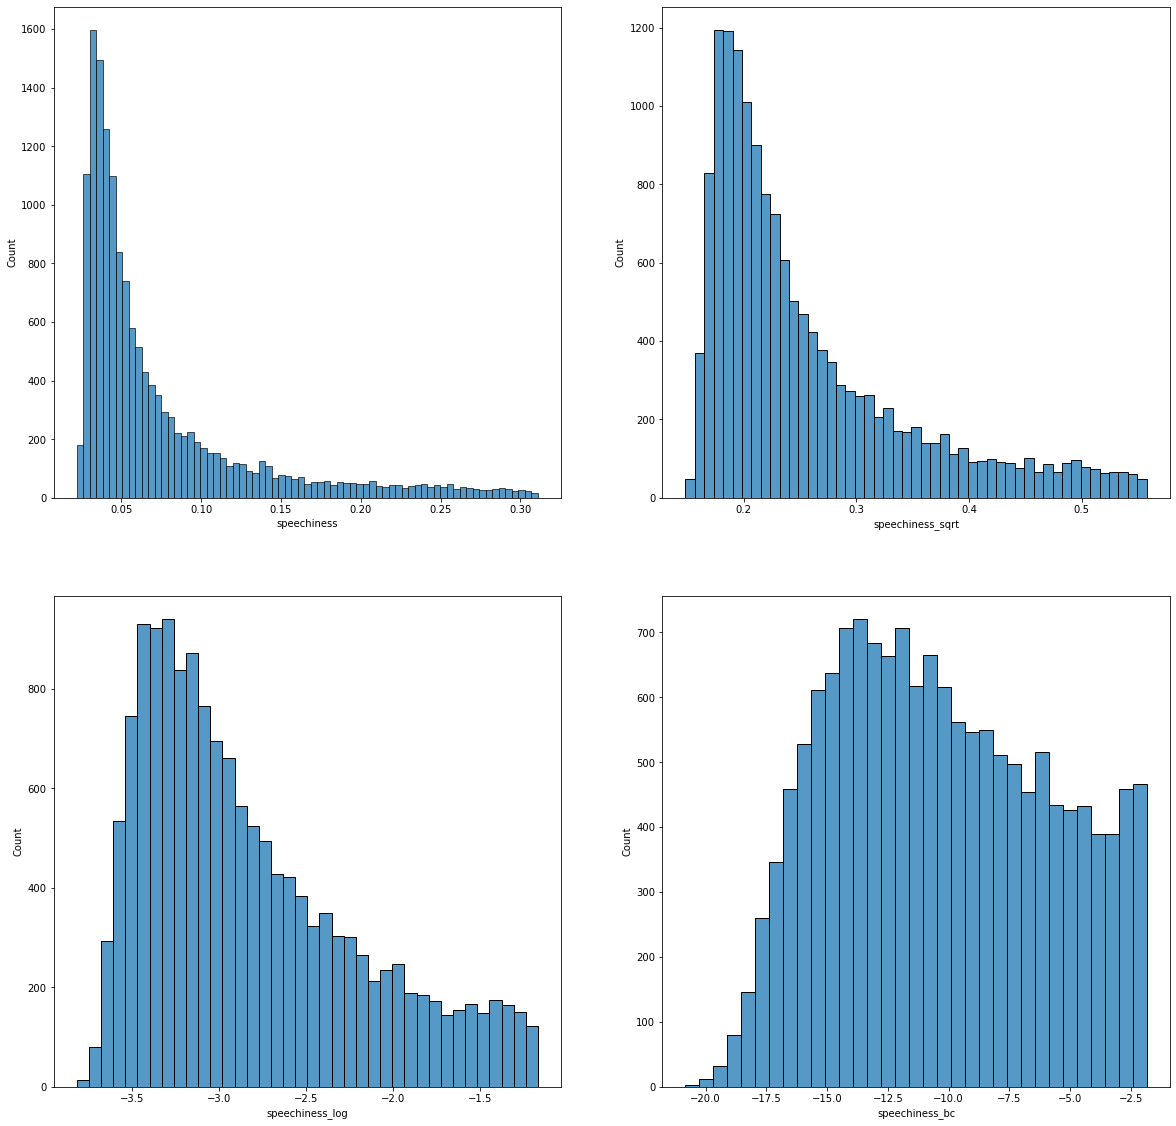

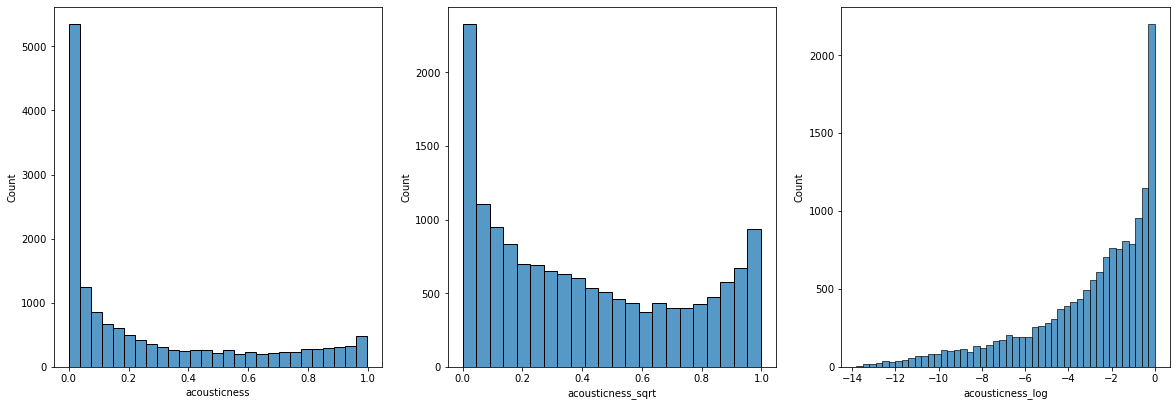

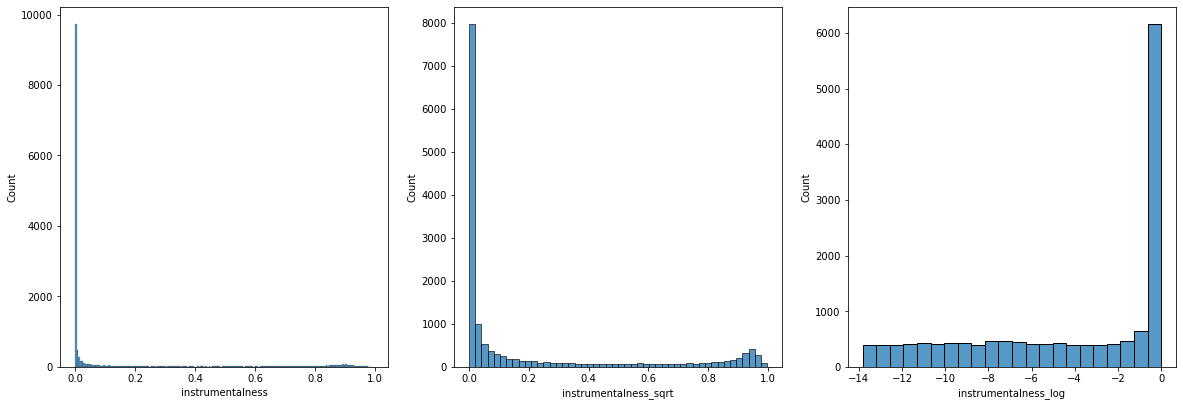

In [248]:
num = transformations(num, "speechiness")
num = transformations(num, "acousticness")
num = transformations(num, "instrumentalness")

sqrt transform looks like a good way to deal with skewness for all three features:

In [249]:
num.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,speechiness_sqrt,speechiness_log,speechiness_bc,acousticness_sqrt,acousticness_log,instrumentalness_sqrt,instrumentalness_log
0,0.393,0.508,-9.421,0.0640,0.1410,0.876000,0.116,0.603,93.054,430053.0,0.252982,-2.748872,-8.814758,0.375500,-1.958995,0.935949,-0.132389
1,0.870,0.488,-5.034,0.0465,0.0307,0.797000,0.652,0.548,116.586,198546.0,0.215639,-3.068303,-11.488210,0.175214,-3.483493,0.892749,-0.226901
2,0.717,0.554,-8.379,0.0768,0.6540,0.000004,0.101,0.610,150.143,197160.0,0.277128,-2.566551,-7.546026,0.808703,-0.424648,0.002017,-12.411868
3,0.945,0.582,-8.357,0.0719,0.1140,0.000000,0.103,0.907,108.025,168906.0,0.268142,-2.632479,-7.985450,0.337639,-2.171557,0.000000,0.000000
4,0.614,0.682,-4.117,0.1020,0.3870,0.000000,0.134,0.566,100.202,169853.0,0.319374,-2.282782,-5.878392,0.622093,-0.949331,0.000000,0.000000


In [250]:
num = num.drop(columns = ["speechiness","acousticness","instrumentalness","speechiness_log","speechiness_bc","acousticness_log","instrumentalness_log"])

In [251]:
num.head()

,danceability,energy,loudness,liveness,valence,tempo,duration_ms,speechiness_sqrt,acousticness_sqrt,instrumentalness_sqrt
0,0.393,0.508,-9.421,0.116,0.603,93.054,430053.0,0.252982,0.375500,0.935949
1,0.870,0.488,-5.034,0.652,0.548,116.586,198546.0,0.215639,0.175214,0.892749
2,0.717,0.554,-8.379,0.101,0.610,150.143,197160.0,0.277128,0.808703,0.002017
3,0.945,0.582,-8.357,0.103,0.907,108.025,168906.0,0.268142,0.337639,0.000000
4,0.614,0.682,-4.117,0.134,0.566,100.202,169853.0,0.319374,0.622093,0.000000


Encoding cats:

In [300]:
cat.columns

Index(['key', 'mode', 'time_signature', 'main_genre'], dtype='object')

In [305]:
y = cat["main_genre"]
y = pd.DataFrame(y)
cat = cat.drop(columns="main_genre")

In [253]:
cat["time_signature"] = cat["time_signature"].astype("category")

In [254]:
cat_hot=pd.get_dummies(cat, drop_first=True)

In [255]:
cat_hot.head()

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1,time_signature_3.0,time_signature_4.0,time_signature_5.0
0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


# Normalizing:

In [256]:
X = num.copy()

In [257]:
STDC = StandardScaler()
STDC.fit(X)

StandardScaler()

In [258]:
X_prep = STDC.transform(X)

In [260]:
X_standardized = pd.DataFrame(X_prep, index=X.index)
X_standardized.columns = X.columns
X_standardized.head()

,danceability,energy,loudness,liveness,valence,tempo,duration_ms,speechiness_sqrt,acousticness_sqrt,instrumentalness_sqrt
0,-1.062733,-0.588066,-0.307787,-0.488572,0.195500,-0.980481,2.935623,-0.047701,-0.097667,2.279095
1,1.693707,-0.669595,0.765048,2.580221,-0.015201,-0.189383,-0.520418,-0.457791,-0.715291,2.145066
2,0.809566,-0.400549,-0.052967,-0.574452,0.222316,0.938735,-0.541109,0.217458,1.238210,-0.618435
3,2.127110,-0.286408,-0.047587,-0.563001,1.360101,-0.477186,-0.962897,0.118774,-0.214419,-0.624694
4,0.214360,0.121237,0.989299,-0.385515,0.053756,-0.740180,-0.948760,0.681387,0.662758,-0.624694


# Concat with encoded data and export for modeling purposes:

In [261]:
X = pd.concat([cat_hot,X_standardized], axis =1)

In [262]:
X.shape

(15125, 25)

In [263]:
X.head()

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1,time_signature_3.0,time_signature_4.0,time_signature_5.0,danceability,energy,loudness,liveness,valence,tempo,duration_ms,speechiness_sqrt,acousticness_sqrt,instrumentalness_sqrt
0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,-1.062733,-0.588066,-0.307787,-0.488572,0.195500,-0.980481,2.935623,-0.047701,-0.097667,2.279095
1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1.693707,-0.669595,0.765048,2.580221,-0.015201,-0.189383,-0.520418,-0.457791,-0.715291,2.145066
2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.809566,-0.400549,-0.052967,-0.574452,0.222316,0.938735,-0.541109,0.217458,1.238210,-0.618435
3,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2.127110,-0.286408,-0.047587,-0.563001,1.360101,-0.477186,-0.962897,0.118774,-0.214419,-0.624694
4,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.214360,0.121237,0.989299,-0.385515,0.053756,-0.740180,-0.948760,0.681387,0.662758,-0.624694


In [307]:
data_prep = pd.concat([X,y],axis=1)

In [308]:
data_prep.to_pickle('data_prep_balanced1000.pickle')